# QPGA fidelity search

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import qutip

import sys; sys.path.append("../../../Archive/Research/INQNET/superdense")
import squanch

from keras import backend as K
from keras.models import Sequential
from keras.optimizers import SGD, Adam

from tqdm import tqdm_notebook as pbar

K.set_floatx('float64')

from qpga import *

Using TensorFlow backend.


In [2]:
def QFT(qubits):
    '''Applies quantum Fourier transform to inputs'''
    count = 0
    N = len(qubits)
    for n in range(N, 0, -1):
        target = qubits[N - n]
        squanch.H(target)
        count += 1
        for m in range(1, n):
            squanch.CPHASE(qubits[N - n + m], target,2*np.pi/2**(m+1))
            count += 1
    return count

In [3]:
N = 6
states = np.array([get_random_state_vector(N) for _ in range(10000)])
states[0] = np.array([1]  + [0] * (2**N - 1), dtype=np.complex128)

qstream = squanch.QStream.from_array(np.copy(states), use_density_matrix=False)
for qsys in qstream:
    gate_depth = QFT(list(qsys.qubits))
print(gate_depth)
    
out_states = np.copy(qstream.state)

in_data = np_to_k_complex(states)
out_data = np_to_k_complex(out_states)

learning_rate = 0.001 # 2**N * 0.001 

depths = N + 3 * np.array([1, 2, 3, 4, 5, 6, 7, 8, 8, 10])
fidelities = []

for depth in pbar(depths):
    
    model = QPGA(N, depth).as_sequential()
    model.compile(optimizer=Adam(lr=learning_rate), 
                  loss=antifidelity, 
                  metrics=[antifidelity, 'mse'])

    callback = keras.callbacks.History()
    history = model.fit(in_data, out_data, epochs=15, callbacks=[callback], verbose = 0)
    
    fidelity = 1 - history.history["antifidelity"][-1]
    fidelities.append(fidelity)

21


W0722 17:44:12.041096 4657685952 deprecation_wrapper.py:119] From /Users/ben/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0722 17:44:12.066020 4657685952 deprecation_wrapper.py:119] From /Users/ben/anaconda3/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0722 17:44:12.066792 4657685952 deprecation_wrapper.py:119] From /Users/ben/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0722 17:44:12.080037 4657685952 deprecation_wrapper.py:119] From /Users/ben/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0722 17:44:16.458682 4657685952 dep

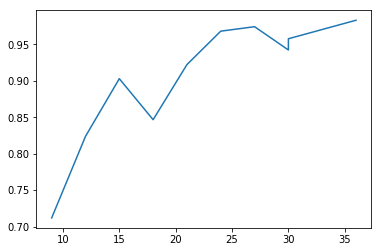

In [6]:
plt.plot(depths, fidelities)

In [7]:
fidelities, depths

([0.7118584964904024,
  0.8237913567675316,
  0.9029546611317794,
  0.8466680930962479,
  0.9222951509934948,
  0.9681834179327199,
  0.9743086181235378,
  0.9423790183295163,
  0.9577675755668338,
  0.9831654438735083],
 array([ 9, 12, 15, 18, 21, 24, 27, 30, 30, 36]))